# Пайплайны для обучения LLM: pretrain и SFT

---

## Pretrain

Цель — с нуля обучить LLM на корпусе текстов русской классической литературы, чтобы модель понимала базовую структуру
языка и могла выдавать более-менее осмысленные продолжения текстов.

### Сбор данных

Скачаем корпус текстов и поместим его в датасет.

In [1]:
import requests
from datasets import Dataset, DownloadManager

CORPUS_URL = 'https://api.github.com/repos/JoannaBy/RussianNovels/contents/corpus'
corpus_info = requests.get(CORPUS_URL).json()
file_urls = {f['name']: f['download_url'] for f in corpus_info if f['type'] == 'file'}
download_manager = DownloadManager(dataset_name='russian_novels')
file_paths = download_manager.download(file_urls)

def load_examples():
    for file_name, file_path in file_paths.items():
        with open(file_path, encoding='utf-8') as f:
            yield {'file_name': file_name, 'text': f.read()}

text_ds = Dataset.from_generator(load_examples)
text_ds

Dataset({
    features: ['file_name', 'text'],
    num_rows: 108
})

### Подготовка текстов для обучающего датасета

Цели:
1. привести в порядок форматирование исходных текстов;
2. удалить предложения, содержащие некириллические слова;
3. удалить текст, который не относится к содержанию произведений (номера глав, эпиграфы, и т.п.);
4. разбить тексты на небольшие синтаксически связанные чанки примерно одинаковой длины.

Реализуем функцию для очистки и нормализации исходного текста.

In [2]:
import re

def clean_text(text: str):
    text = text.strip()
    for pattern, replacement in [
        (r'_+|\s+', ' '),  # заменяет разделительные символы на пробелы
        (r' ?\.{2,} ?', '… '),  # нормализует многоточие
        (r'(No?) ?(?=\d+)', '№ '),  # нормализует знак номера
        (r' ?--+ ?| - |^- | ?– ?', ' — '),  # нормализует тире
        (r'([«„(]) ', r'\1'),  # нормализует открывающиеся скобки и кавычки
        (r' ([»“)])', r'\1'),  # нормализует закрывающиеся скобки и кавычки
        (r' ?([\?\!\.,;…]+) ?(["»\)]?)', _normalize_punctuation),  # нормализует знаки препинания
        (r' ?(\{.*?\}|\[.*?\]) ?', ' '),  # удаляет текст в квадратных и фигурных скобках (сноски и т.п.)
        (r'(?<=\w)#(?=\w)', '-'),  # заменяет распространённую опечатку: "#" вместо "-" в середине слова
    ]:
        text = re.sub(pattern, replacement, text)
    return text.strip()

def _normalize_punctuation(match: re.match):
    punctuation, closing_bracket = match.groups()
    return punctuation[0] + (closing_bracket or ' ')

clean_text(' Пример \n  текста!!! [42]')

'Пример текста!'

Для разбивки текста на чанки будем использовать следующий алгоритм:
1.  Разобьём текст на главы, чтобы содержимое двух разных глав не попало в один чанк.
    Поскольку в текстах нет универсальной разметки глав, в качестве разделителя будем использовать пустую строку.
2.  Из полученных текстов отберём те, которые достигают определённой длины, — их и будем считать главами.
    Все остальные тексты отбросим, так как они, скорее всего, будут содержать названия глав, эпиграфы и тому подобное.
3.  Текст внутри каждой главы разобьём на предложения.
4.  Отбросим неподходящие предложения — содержащие некириллические символы или не содержащие ни одной буквы.
5.  Будем последовательно конкатенировать предложения в чанки до тех пор, пока не превысится заранее выбранная длина
    чанка.
    После этого создадим новый чанк — и так до конца главы.
    Если последний чанк в главе окажется слишком коротким, отбросим его.

Таким образом, на выходе получим набор чанков, которые:
* не превышают выбранную длину;
* состоят из законченных предложений;
* состоят из текста какой-то одной главы.

Реализуем функцию разбивки текста на главы.

*Чтобы не засорять оперативную память результатами промежуточных преобразований, будем использовать генераторы.*

In [3]:
def split_text_into_chapters(text: str):
    chapter_text = ''
    is_inside_quotation = False
    for line in text.splitlines():
        line = line.strip()
        if line:
            is_inside_quotation = line.endswith(':')
            chapter_text += (' ' + line if chapter_text else line)
        elif chapter_text and not is_inside_quotation:
            yield chapter_text
            chapter_text = ''
    if chapter_text:
        yield chapter_text

Реализуем функцию разбивки текста на предложения.

In [4]:
def split_text_into_sentences(text: str):
    for match in re.finditer(r'(.*?[.!?…])(?:\s+|$)', text):
        yield match.group(1)

Далее мы реализуем описанные выше предикаты для проверки пригодности глав, предложений и чанков.
Но отброшенные тексты было бы удобно сохранить для дальнейшего анализа — это позволит убедиться в том, что мы не отбросили
ничего лишнего.
Для этой цели сделаем вспомогательный декоратор, который будет складывать такие тексты в специальный список.

In [5]:
def collecting_false_elements(false_elements: list):
    def decorator(predicate):
        def wrapper(element):
            result = predicate(element)
            if not result:
                false_elements.append(element)
            return result
        return wrapper
    return decorator

Теперь реализуем сами предикаты.

In [ ]:
# Списки, куда будем складывать тексты, не попавшие в итоговые чанки.
dropped_chapters = []
dropped_sentences = []
dropped_chunks = []

@collecting_false_elements(dropped_chapters)
def is_normal_chapter(text: str):
    return len(text) > 100

@collecting_false_elements(dropped_sentences)
def is_normal_sentence(text: str):
    ALPHANUMERICALS = '0-9А-Яа-яЁё'
    text = re.sub(r'(?<=\W)[IVXLCDM]+(?=\W)', '', text, flags=re.IGNORECASE)
    return bool(
        re.match(fr'^[{ALPHANUMERICALS} \.,;:"\'«»„“”\?\!…\(\)\-—/=\*\+%№]+$', text) and  # текст состоит из разрешённых символов
        re.search(fr'[{ALPHANUMERICALS}…]', text)  # в тексте есть не только знаки препинания
    )

@collecting_false_elements(dropped_chunks)
def is_normal_chunk(text: str):
    return len(text) > 1000

Наконец, реализуем генератор, который будет выдавать готовые чанки, и применим его, чтобы создать новый датасет.

In [7]:
def split_dataset_into_chunks(ds: Dataset, max_chunk_length=1000, chapter_filter=None, sentence_filter=None, chunk_filter=None):
    for record in ds:
        for chapter in split_text_into_chapters(record['text']):
            chapter = clean_text(chapter)
            if chapter_filter is not None and not chapter_filter(chapter):
                continue
            chunk_text = ''
            for sentence in split_text_into_sentences(chapter):
                if sentence_filter is not None and not sentence_filter(sentence):
                    continue
                new_chunk_text = chunk_text + (' ' + sentence if chunk_text else sentence)
                if len(new_chunk_text) > max_chunk_length:
                    if chunk_text and (chunk_filter is None or chunk_filter(chunk_text)):
                        yield {'text': chunk_text}
                    chunk_text = sentence
                else:
                    chunk_text = new_chunk_text
            if chunk_text and (chunk_filter is None or chunk_filter(chunk_text)):
                yield {'text': chunk_text}

text_chunk_ds = Dataset.from_generator(
    generator=split_dataset_into_chunks,
    gen_kwargs=dict(
        ds=text_ds,
        max_chunk_length=4000,
        chapter_filter=is_normal_chapter,
        sentence_filter=is_normal_sentence,
        chunk_filter=is_normal_chunk,
    ),
    keep_in_memory=True,
    cache_dir='pretrain_dataset',
)
text_chunk_ds

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 11489
})

⚠️ **Важно:** при повторном запуске блокнота может возникнуть проблема.
Дело в том, что генератор `split_dataset_into_chunks` запускается только один раз, а при всех последующих запусках датасет загружается из кэша — такова особенность модуля `datasets`.
Далее мы будем работать со списками `dropped_chapters`, `dropped_sentences` и `dropped_chunks`, но поскольку они заполняются внутри генератора, при повторном запуске блокнота они не будут заполнены.
Чтобы решить эту проблему, нужно вручную удалить директорию `pretrain_dataset`, а затем перезапустить ячейку выше.

In [8]:
import random
random.seed(42)

Посмотрим, как выглядят чанки.

In [9]:
for chunk_text in random.sample(text_chunk_ds['text'], 10):
    print('•', chunk_text)

• И та же госпожа Суханчикова, которая заставляет госпожу Бичер-Стоу бить по щепам Тентелеева, перед Губаревым чуть не ползает. А ведь только за ним и есть, что он умные книжки читает да все в глубину устремляется. Какой у него дар слова, вы сегодня сами судить могли; и это еще слава богу, что он мало говорит, все только ежится. Потому что когда он в духе да нараспашку, так даже мне, терпеливому человеку, невмочь становится. Начнет подтрунивать да грязные анекдотцы рассказывать, да, да, наш великий господин Губарев рассказывает грязные анекдоты и так мерзко смеется при этом… — Будто вы так терпеливы? — промолвил Литвинов. Я, напротив, полагал… Но позвольте узнать, как ваше имя и отчество? Потугин отхлебнул немного киршвассеру. — Меня зовут Созонтом… Созонтом Иванычем. Дали мне это прекрасное имя в честь родственника, архимандрита, которому я только этим и обязан. Я, если смею так выразиться, священнического поколения. А что вы насчет терпенья сомневаетесь, так это напрасно: я терпелив.

Посмотрим, как выглядят отброшенные главы.

In [10]:
for chapter in random.sample(dropped_chapters, 10):
    print('•', chapter)

• Пауза.
• XXVII
• Заняв луга и горы,
• БЮРО ФОТОГРАФИЧЕСКИХ ПРИНАДЛЕЖНОСТЕЙ
• ПРЕДИСЛОВИЕ
• 2 Вечным двигателем (лат.).
• III
• III
• XVI
• III


Туда действительно попали в основном заголовки, номера глав и сноски — они не нужны для обучения.

Посмотрим, как выглядят отброшенные предложения.

In [11]:
for sentence in random.sample(dropped_sentences, 10):
    print('•', sentence)

• Баба и мужик — cela commence а?
• Офицер этот, вероятно, штабный, с списком в руках, сделал перекличку всем русским, назвав Пьера: celui qui n'avoue pas son nom.
• Здоровый, прекрасно одeтый, очень моложавый, я блуждал по только что описанным мeстам, — и тайное вдохновение меня не обмануло, я нашел то, чего бессознательно искал.
• А Параша думала: "на всю зиму!" и глядѣла на Петра изъ уголка.
• .
• — Sire!
• Чѣмъ вы обижаетесь?
• Вот видишь, ты до такой степени привык к своей убогой судьбe, что сейчас едва ли улавливаешь мою мысль, — моя рeчь тебe кажется непонятной, странной; то, что впереди, покажется тебe еще непонятнeе и страннeе”.
• Мать глупа, соблазнъ близко, въ городъ ѣздятъ безпрестанно; jugez, que peut on attendre?
• Я задремала, какъ вдругъ послышались вдали звуки колокольчика, а затѣмъ топотъ коней и грохотъ колесъ нашей тяжелой коляски.


Большинство из них содержат символы, которые не входят в современный русский алфавит, а значит, фильтр предложений работает правильно.

Посмотрим, как выглядят отброшенные чанки.

In [12]:
for chunk in random.sample(dropped_chunks, 10):
    print('•', chunk)

• Он снова подмигнул девкам и вдруг перевёл голосишко на плясовой лад, а дочь его, по-цыгански закинув руки за голову, встряхивая грудями, взвизгнула и пошла плясать под звонкую песенку отца и струнный звон.
• Наполеон нахмурился и долго молча сидел, опустив голову на руку. — вопросительно сказал он. Наполеон взял пастильку, положил ее в рот и посмотрел на часы. Спать ему не хотелось, до утра было еще далеко; а чтобы убить время, распоряжений никаких нельзя уже было делать, потому что все были сделаны и приводились теперь в исполнение. — строго спросил Наполеон.
• И тут Фомушка: Так сердце странно в горе, Как лодка гибнет в море… На что ж оно дано? На зло, на зло, на зло!
• Идут, идут мимо окровавленные тени, бегут видения, растрепанные девичьи косы, тюрьмы, стрельба, и мороз, и полночный крест Владимира.
• — Это совсем не то, — сказал он. — Разве это польская мазу'ка? А отлично танцует. — Зная, что Денисов и в Польше даже славился своим мастерством плясать польскую мазурку, Николай по

Как и следовало ожидать, туда попадают слишком короткие "хвосты" глав — не будем использовать их для обучения.

Чтобы убедиться, что мы не отбросили слишком много исходного текста, посчитаем отношение общего
количества символов во всех текстах датасета до и после разбивки на чанки и вычислим их отношение.
Будем учитывать только видимые (не whitespace) символы.

In [13]:
def count_visible_characters(ds: Dataset):
    result = 0
    for record in ds:
        result += len(re.sub(r'\s+', '', record['text']))
    return result

text_preservation_ratio = count_visible_characters(text_chunk_ds) / count_visible_characters(text_ds)
print(f'Сохранено исходного текста: {text_preservation_ratio:.2%}')

Сохранено исходного текста: 91.89%


В датасете сохранилось более 90% оригинального текста — такая цифра является вполне приемлемой.

Построим распределение длин текстов.

Map:   0%|          | 0/11489 [00:00<?, ? examples/s]

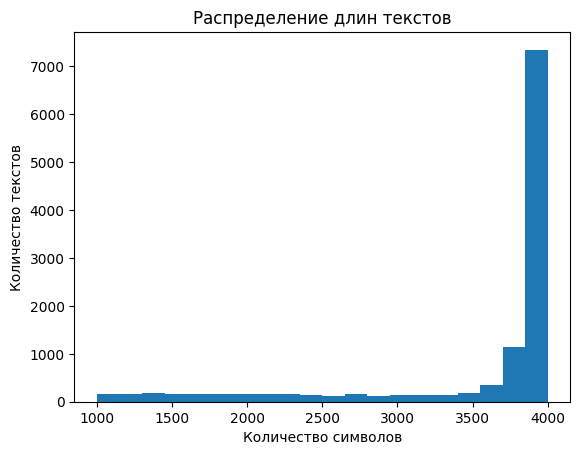

In [14]:
import matplotlib.pyplot as plt

text_lengths = text_chunk_ds.map(lambda x: {'text_length': len(x['text'])})['text_length']
plt.hist(text_lengths, bins=20)
plt.title('Распределение длин текстов')
plt.xlabel('Количество символов')
plt.ylabel('Количество текстов')
plt.show()

Хвост распределения образован концами глав, которых не хватило, чтобы полностью заполнить чанк.

### Обучение

Создадим и обучим новый токенизатор на подготовленных выше текстах.

In [15]:
from tokenizers import Tokenizer, pre_tokenizers, models as tokenizer_models, trainers as tokenizer_trainers

SPECIAL_TOKENS = {
    'unk_token': '<unk>',
    'pad_token': '<pad>',
    'bos_token': '<s>',
    'eos_token': '</s>',
}

tokenizer = Tokenizer(tokenizer_models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
tokenizer.train_from_iterator(
    trainer=tokenizer_trainers.BpeTrainer(
        vocab_size=30000,
        min_frequency=2,
        special_tokens=list(SPECIAL_TOKENS.values()),
        show_progress=True,
    ),
    iterator=text_chunk_ds['text'],
    length=len(text_chunk_ds),
)
tokenizer.save('tokenizer.json')

Загрузим полученный токенизатор.

In [16]:
from transformers import PreTrainedTokenizerFast

tokenizer = PreTrainedTokenizerFast(tokenizer_file='tokenizer.json', **SPECIAL_TOKENS)

Токенизируем датасет с текстами.

In [17]:
def tokenize_batch(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=512,
        return_attention_mask=False,
    )

tokenized_ds = text_chunk_ds.map(tokenize_batch, batched=True, remove_columns=['text'], desc='Tokenizing')
tokenized_ds

Tokenizing:   0%|          | 0/11489 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'token_type_ids'],
    num_rows: 11489
})

Инициализируем LLM.

In [18]:
from transformers import LlamaConfig, LlamaForCausalLM

model = LlamaForCausalLM(
    config=LlamaConfig(
        vocab_size=tokenizer.vocab_size,
        max_position_embeddings=512,
        hidden_size=1024,
        intermediate_size=1536,
        num_hidden_layers=16,
        num_attention_heads=16,
        num_key_value_heads=8,
        bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    ),
)

Реализуем callback, который в процессе обучения будет с определённой периодичностью тестировать модель на заранее подготовленных промптах и записывать сгенерированные тексты в файл.
В тот же файл будем записывать номер шага, эпоху и значение ошибки.

In [ ]:
from contextlib import contextmanager
from transformers import TrainerCallback, pipeline
import csv
import pandas as pd

class InferenceLogCallback(TrainerCallback):
    def __init__(self, prompts, tokenizer, log_filename, gen_kwargs=None, append_log=False):
        self.prompts = prompts
        self.tokenizer = tokenizer
        self.gen_kwargs = gen_kwargs or {}
        self.log_filename = log_filename
        if not append_log:
            self.clean_log_file()
    
    def clean_log_file(self):
        with self._get_dumper(mode='w') as dumper:
            dumper.writerow(['step', 'epoch', 'loss'] + self.prompts)

    def on_log(self, args, state, control, model, **kwargs):
        text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer)
        generated_data = text_generator(self.prompts, **self.gen_kwargs)
        with self._get_dumper() as dumper:
            dumper.writerow(
                [
                    state.global_step,
                    format(state.epoch, '.4f'),
                    format(state.log_history[-1].get('loss', float('nan')), '.4f'),
                    *(entry[0]['generated_text'] for entry in generated_data),
                ]
            )
        model.train()

    def build_log_df(self):
        return (
            pd.read_csv(self.log_filename, sep='\t', index_col=list(range(3)))
            .rename_axis(columns='prompt')
            .stack()
            .rename('generated_text')
            .reset_index(['epoch', 'loss'])
        )

    @contextmanager
    def _get_dumper(self, mode='a'):
        with open(self.log_filename, mode, encoding='utf-8', newline='') as log_file:
            yield csv.writer(log_file, delimiter='\t')

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling

# True - продолжить цикл обучения, начатый ранее;
# False - начать цикл обучения сначала.
RESUME_TRAINING = False

pretrain_log_callback = InferenceLogCallback(
    prompts=[
        "Все мысли, которые имеют огромные последствия",
        "Сила войска зависит от его духа",
        "Мысль о том, что он принес страдания",
        "Человек сознает себя свободным",
        "Что бы ни случилось, я всегда буду",
        "Любовь мешает смерти",
        "Нет, жизнь не кончена",
        "Всякая мысль, даже самая простая",
        "Война не любезность, а самое гадкое дело",
        "Чтобы жить честно"
    ],
    tokenizer=tokenizer,
    gen_kwargs=dict(
        max_new_tokens=100,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=1,
        num_return_sequences=1,
    ),
    log_filename='pretrain_log.tsv',
    append_log=RESUME_TRAINING,
)
trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir='pretrain_model',
        overwrite_output_dir=True,
        num_train_epochs=8,
        per_device_train_batch_size=8,
        learning_rate=5e-5,
        weight_decay=0.01,
        warmup_steps=500,
        fp16=True,
        logging_first_step=True,
        logging_steps=200,
        save_steps=200,
        save_total_limit=3,
        prediction_loss_only=True,
        dataloader_pin_memory=True,
    ),
    train_dataset=tokenized_ds,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
    callbacks=[pretrain_log_callback],
)
trainer.train(resume_from_checkpoint=RESUME_TRAINING)
trainer.save_model()

Device set to use cuda:0


Step,Training Loss


### Анализ результатов

Посмотрим, какие данные собрались в процессе обучения.

In [30]:
pretrain_log_df = pretrain_log_callback.build_log_df()
pretrain_log_df

epoch     loss  \
step  prompt                                                           
1     Все мысли, которые имеют огромные последствия  0.0007  10.5617   
      Сила войска зависит от его духа                0.0007  10.5617   
      Мысль о том, что он принес страдания           0.0007  10.5617   
      Человек сознает себя свободным                 0.0007  10.5617   
      Что бы ни случилось, я всегда буду             0.0007  10.5617   
...                                                     ...      ...   
11496 Любовь мешает смерти                           8.0000      NaN   
      Нет, жизнь не кончена                          8.0000      NaN   
      Всякая мысль, даже самая простая               8.0000      NaN   
      Война не любезность, а самое гадкое дело       8.0000      NaN   
      Чтобы жить честно                              8.0000      NaN   

                                                                                        generated_text  
step  prompt                                                                                            
1     Все мысли, которые имеют огромные последствия  Все мысли, которые имеют огромные последствия ...  
      Сила войска зависит от его духа                Сила войска зависит от его духа лампу иски Вар...  
      Мысль о том, что он принес страдания           Мысль о том, что он принес страдания хает сред...  
      Человек сознает себя свободным                 Человек сознает себя свободным нетерпения рени...  
      Что бы ни случилось, я всегда буду             Что бы ни случилось, я всегда буду постоянной ...  
...                                                                                                ...  
11496 Любовь мешает смерти                           Любовь мешает смерти это нужно было думать. Он...  
      Нет, жизнь не кончена                          Нет, жизнь не кончена, ты не скажешь, ты скажи...  
      Всякая мысль, даже самая простая               Всякая мысль, даже самая простая, когда он хот...  
      Война не любезность, а самое гадкое дело       Война не любезность, а самое гадкое дело на ег...  
      Чтобы жить честно                              Чтобы жить честно. И, я он хотел сказать с нею...  

[630 rows x 3 columns]

Выведем тексты, которые модель сгенерировала в конце обучения.

In [31]:
last_step = pretrain_log_df.index.get_level_values('step').max()
for prompt, generated_text in pretrain_log_df.loc[last_step].generated_text.items():
    print('•', prompt + '...\n  ⮡ ', generated_text)

• Все мысли, которые имеют огромные последствия...
  ⮡  Все мысли, которые имеют огромные последствия. Он видел, что это и что он не понимает того, что он видел, и не говорил этого. Он чувствовал это ; но он не мог забыть. Князь Василий смотрел на нее. И ему говорили : не потому ли, чтобы он был прежде, то, чтобы он считал себя, как будто его никогда не бывает, а не от которого и не могло понять и не хотел верить, но он мог сказать что - нибудь. Он видел это по - русски, и не ждал его. И он
• Сила войска зависит от его духа...
  ⮡  Сила войска зависит от его духа и то же пяти, то есть как можно же, именно это это место! Это был очень много лет и был один из них, с некоторым видом не более на то, что у него есть сердце. Это был князь ; однако же он сидел в том, что мог ли ему сделать это дело до самого моего дела. Он мог так говорить и о своем положении, что не мог он видеть ее, что он не мог не в этом случае быть и не мог себе. Когда это было тогда и он
• Мысль о том, что он принес стр

Возьмём один промпт и проследим, как менялся сгенерированный текст по мере обучения.
Чтобы не печатать весь лог, рассмотрим только 10 этапов обучения, постепенно увеличивая количество шагов между ними.

In [32]:
import numpy as np

selected_prompt = pretrain_log_df.index.get_level_values('prompt')[0]
step_bounds = list(np.geomspace(last_step, 1, 10))
print(selected_prompt + '...\n')
for (step, prompt), (epoch, loss, generated_text) in pretrain_log_df.iterrows():
    if prompt == selected_prompt and step >= step_bounds[-1]:
        print(f'• {step=}, {epoch=}, {loss=}', '\n  ⮡ ', generated_text)
        step_bounds.pop()

Все мысли, которые имеют огромные последствия...

• step=1, epoch=0.0007, loss=10.5617 
  ⮡  Все мысли, которые имеют огромные последствия Кругу всяким Берлиоз тельств поведет Кругу стреляли буя покорность косо спросит уста др поведет головка выходило ковое ковое Ребята поведет познакомилась тельств столкнулся заняли Крэйтон прибли тельств наоборот столкнулся деревьями похо постой вор кром виконт вор щебе милым постой косо прибли тельств биль грудь прой прибли вании совершен похо Агаф зары истина интри седой грудь вании биль поблески ир дович вании няло прибли седой интри прой родня совершен вании жье похо зары колени комната криком гиня спросит алист щебе истори родня вании болела обеим снов вании шало снов темноту скула благоговением пациент явным приход няло постой обеим седой кафта поддель
• step=200, epoch=0.1392, loss=8.8077 
  ⮡  Все мысли, которые имеют огромные последствия, — — то в и и и, его,. — по я. с, —! не я, и я, в — и у, в! — к в за. — что все, в и, все. — не, : —. — н

Отразим на графике, как меняется ошибка в процессе обучения.

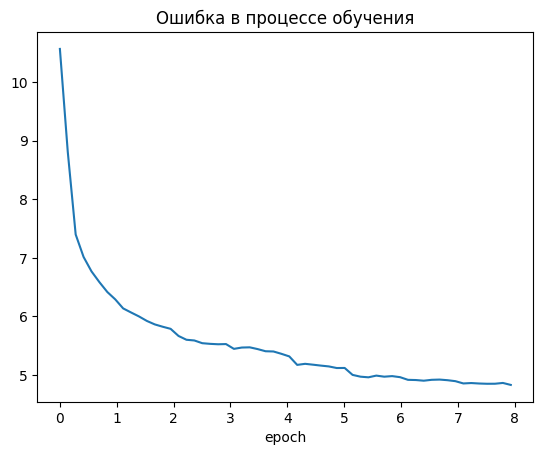

In [33]:
pretrain_log_df.dropna().groupby('epoch').loss.first().plot(title='Ошибка в процессе обучения');

## Вывод

Большая языковая модель была с нуля обучена пониманию структуры русского языка на предварительно подготовленном корпусе литературы.
В процессе обучения был собран журнал, демонстрирующий, как постепенно растёт качество сгенерированных текстов.
Финальные тексты демонстрируют достаточно хорошую синтаксическую связность: большинство слов корректно согласуются со своими соседями; обороты, прямая речь и другие конструкции выделяются соответствующими знаками препинания, а весь текст разбит на предложения.

---

## SFT

Цель — дообучить базовую LLM на русскоязычном инструктивном датасете.

Загрузим датасет.

In [1]:
from datasets import load_dataset

ds = load_dataset('d0rj/alpaca-cleaned-ru', split='train', cache_dir='sft_dataset')
ds

Dataset({
    features: ['input', 'instruction', 'output'],
    num_rows: 51760
})

Преобразуем датасет так, чтобы он содержал колонку `messages` с цепочкой сообщений.

In [2]:
def build_messages(example):
    if example['input']:
        user_message = example['instruction'] + '\n\n' + example['input']
    else:
        user_message = example['instruction']
    return {
        'messages': [
            {'role': 'user', 'content': user_message},
            {'role': 'assistant', 'content': example['output']},
        ]
    }

message_ds = ds.map(build_messages, remove_columns=ds.column_names)
message_ds

Dataset({
    features: ['messages'],
    num_rows: 51760
})

Загрузим базовую модель.

In [9]:
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_NAME = 'Qwen/Qwen2.5-0.5B'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to('cuda')

Реализуем функцию для демонстрации инференса на тестовых промптах и посмотрим, что она выдаёт для базовой модели.

In [ ]:
from transformers import pipeline
from textwrap import indent

TEST_PROMPTS = [
    'сколько планет в нашей солнечной системе?',
    'расскажи стих',
    'когда собирать крыжовник?',
    'Как быстро выучить новый язык?',
]

def show_model_output(model, tokenizer, prompts):
    text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer)
    generated_data = text_generator([[{'role': 'user', 'content': prompt}] for prompt in prompts])
    for prompt, generated_entry in zip(prompts, generated_data):
        print('• ' + prompt + '\n')
        print(indent(generated_entry[0]['generated_text'][-1]['content'], '    ') + '\n')

show_model_output(model, tokenizer, TEST_PROMPTS)

Device set to use cuda:0


• сколько планет в нашей солнечной системе?

    ответ: 24
    })();
    onica1311
    42
    })();
    onica1311
    42
    })();
    onica1311
    42
    })();
    onica1311
    42
    })();
    onica1311
    42
    })();
    onica1311
    42
    })();
    onica1311
    42
    })();
    onica1311
    42
    })();
    onica1311
    42
    })();
    onica1311
    42
    })();
    onica1311
    42
    })();
    onica1311
    42
    })();
    onica1311
    42
    })();
    onica1311
    42
    })();
    onica1311
    42
    })();
    onica1311
    42
    })();
    onica1311
    42
    })();
    onica1311
    42
    })();
    onica1311
    42
    })();
    onica1311
    42
    })();
    onica1311
    42
    })();
    onica1311
    42
    })();
    onica1311
    42
    })();
    onica1311
    42
    })();
    onica1311
    42


• расскажи стих

    Читаем стих Crimea! (Германия)
     Crimea! (Германия) - это моя любимая страна, которую я люблю, и о чем часто говорю. Это страна, которая все

Как видно из ответов, модель выдаёт много нерелевантной информации, повторяющихся слов и текста не на русском языке.

Запустим цикл дообучения модели на выборке из датасета.

In [ ]:
from trl import SFTTrainer, SFTConfig

trainer = SFTTrainer(
    model=model,
    args=SFTConfig(
        output_dir='sft_model',
        save_steps=500,
        logging_first_step=True,
        logging_steps=100,
        per_device_train_batch_size=1,
        max_length=1024,
        num_train_epochs=1,
        lr_scheduler_type='cosine',
        learning_rate=5e-5,
        report_to='none',
        run_name='SFT',
        save_total_limit=3,
    ),
    train_dataset=message_ds.select(range(5000)),
    processing_class=tokenizer,
)
trainer.train(resume_from_checkpoint=True)

Tokenizing train dataset:   0%|          | 0/5000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/5000 [00:00<?, ? examples/s]

Step,Training Loss
1,2.319100
100,2.273500
200,2.337700
300,2.401000
400,2.249700
500,2.239600
600,2.211300
700,2.130800
800,2.049300
900,2.130600


TrainOutput(global_step=5000, training_loss=1.7993637998104095, metrics={'train_runtime': 4366.557, 'train_samples_per_second': 1.145, 'train_steps_per_second': 1.145, 'total_flos': 2850490965763584.0, 'train_loss': 1.7993637998104095, 'epoch': 1.0})

Загрузим дообученную модель и снова посмотрим на результат.

In [17]:
sft_model = AutoModelForCausalLM.from_pretrained('sft_model')
show_model_output(sft_model, tokenizer, TEST_PROMPTS)

Device set to use cuda:0


• сколько планет в нашей солнечной системе?

    Вот 8 планет: планеты Земля, планеты Солнечная, планеты Азия, планеты Азия, планеты Европа, планеты Азия, планеты Европа, планеты Гренадины, планеты Сент-Карта, планеты Леса, планеты Азия, планеты Сент-Карта, планеты Азия, планеты Европа, планеты Азия, планеты Европа, планеты Гренадины, планеты Сент-Карта, планеты Азия, планеты Сент-Карта, планеты Азия, планеты Европа, планеты Азия, планеты Европа, планеты Гренадины, планеты Сент-Карта, планеты Азия, планеты Сент-Карта, планеты Азия, планеты Европа, планеты

• расскажи стих

    Темновая тень, гостеприимная,
    Нагидающая мелодии, теневая пагубность
    Вину и печаль, огоньком разочаро-восторжества
    Светит и радикальность, вдохновение и вероятность,
    Полная возвышенность, наводующие на трепетие и извинение,
    Беспреденность и страх, пыльная страсть,
    Рефакторение. И все это, имена, и судьба, и неудобства,
    Вину и печаль, огоньком разочаро-восторжества, наводующие на трепет

Ответы по-прежнему далеки от идела, в них много бессмысленного текста и ложной информации, но можно заметить явные улучшения:
* ответы стали более релевантными запросу;
* в них стало меньше постороннего текста и повторений;
* они стали полностью на русском языке.

## Вывод

Дообучение LLM на инструктивном датасете показало заметный прирост качества ответов на тестовые запросы.